In [1]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import warnings

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x:'%.2f' % x)
pd.set_option('display.width', 1000)
warnings.filterwarnings ("ignore")

In [2]:
df_ = pd.read_excel("/kaggle/input/online-retail-ii-dataset/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df = df_.copy()

In [3]:
def check_data(dataframe, head=5):
    print("######### SHAPE #########")
    print(dataframe.shape)
    print("######### INFO #########")
    print(dataframe.info())
    print("######### DESCRIBE #########")
    print(dataframe.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print("######### NA VALUES #########")
    print(dataframe.isnull().sum())
    print("######### FIRST {} ROWS #########".format (head))
    print(dataframe.shape)

In [4]:
check_data(df)

######### SHAPE #########
(525461, 8)
######### INFO #########
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
######### DESCRIBE #########
       Quantity                    InvoiceDate     Price  Customer ID
count 525461.00                         525461 525461.00    417534.00
mean      10.34  2010-06-28 11:37:36.845017856      4.69     15360.65
m

In [5]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[(df["Quantity"] > 0)]
df.dropna(inplace=True)

In [6]:
df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99])

,Quantity,InvoiceDate,Price,Customer ID
count,407695.00,407695,407695.00,407695.00
mean,13.59,2010-07-01 10:10:10.782178048,3.29,15368.50
min,1.00,2009-12-01 07:45:00,0.00,12346.00
1%,1.00,2009-12-02 15:10:00,0.29,12435.00
10%,1.00,2010-01-19 11:01:00,0.65,13044.00
25%,2.00,2010-03-26 14:01:00,1.25,13997.00
50%,5.00,2010-07-09 15:46:00,1.95,15321.00
75%,12.00,2010-10-14 17:09:00,3.75,16812.00
90%,24.00,2010-11-18 10:37:00,6.75,17706.00
95%,36.00,2010-11-28 13:53:00,8.50,17913.00


In [7]:
df[df["Price"]==0]["StockCode"].unique()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [8]:
df = df[df["StockCode"] != "M"]

In [9]:
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()

invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [10]:
df[df["StockCode"].isin (invalid_codes)].groupby(["StockCode"]).agg({"Invoice":"nunique",
                                                                    "Quantity":"sum",
                                                                    "Price":"sum",
                                                                    "Customer ID":"nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


In [11]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)

In [12]:
check_data(df)

######### SHAPE #########
(406450, 8)
######### INFO #########
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406450 entries, 0 to 406449
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406450 non-null  object        
 1   StockCode    406450 non-null  object        
 2   Description  406450 non-null  object        
 3   Quantity     406450 non-null  int64         
 4   InvoiceDate  406450 non-null  datetime64[ns]
 5   Price        406450 non-null  float64       
 6   Customer ID  406450 non-null  float64       
 7   Country      406450 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
######### DESCRIBE #########
       Quantity                    InvoiceDate     Price  Customer ID
count 406450.00                         406450 406450.00    406450.00
mean      13.62  2010-07-01 10:28:27.142083840      3.01     15373.48
m

In [13]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [14]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00


In [15]:
df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99])

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,406450.00,406450,406450.00,406450.00,406450.00
mean,13.62,2010-07-01 10:28:27.142083840,3.01,15373.48,21.36
min,1.00,2009-12-01 07:45:00,0.00,12346.00,0.00
1%,1.00,2009-12-02 15:04:00,0.29,12437.00,0.65
10%,1.00,2010-01-19 10:41:00,0.65,13050.00,2.10
25%,2.00,2010-03-26 14:01:00,1.25,14006.00,4.95
50%,5.00,2010-07-09 15:48:00,1.95,15325.00,11.85
75%,12.00,2010-10-14 17:09:00,3.75,16814.00,19.50
90%,24.00,2010-11-18 10:37:00,6.75,17706.00,35.40
95%,36.00,2010-11-28 13:51:00,8.50,17913.00,66.00


In [16]:
max_invoice_date = df["InvoiceDate"].max()
today_date = (max_invoice_date + dt.timedelta (days=2))

In [17]:
today_date

Timestamp('2010-12-11 20:01:00')

In [18]:
max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [19]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,
                                     "Invoice":"nunique",
                                     "TotalPrice":"sum"})

In [20]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [21]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [22]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [23]:
rfm.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99])

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.43,2025.18
std,96.35,7.95,8829.91
min,2.00,1.00,1.55
1%,2.00,1.00,40.76
10%,9.00,1.00,157.03
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
90%,255.00,9.00,3761.56


In [24]:
def select_country(dataframe, country):
    new_dataframe = dataframe.loc[datafrane["Country"] == country]
    return new_dataframe

In [25]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [26]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else :
        return False


In [27]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [28]:
for col in rfm.columns:
    print(col, check_outlier(rfm, col))

Recency False
Frequency True
Monetary True


In [29]:
for col in rfm.columns:
    replace_with_thresholds (rfm, col)

In [30]:
rfm.describe()

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.11,1588.58
std,96.35,4.89,2523.16
min,2.00,1.00,1.55
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
max,375.00,31.00,15243.20


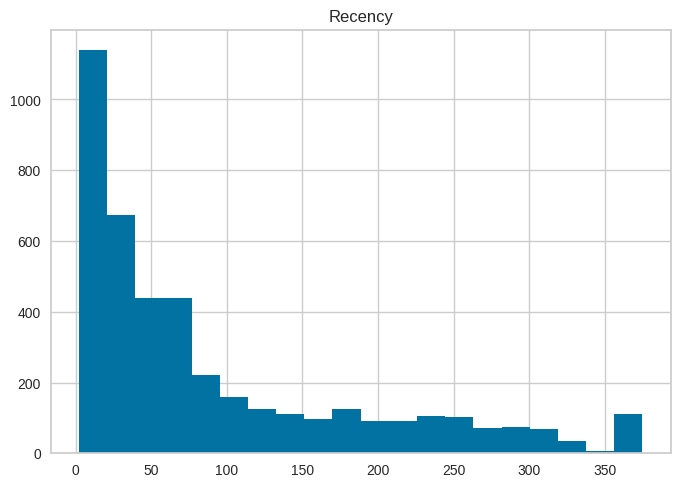

In [31]:
rfm["Recency"].hist (bins=20)
plt.title("Recency")
plt.show()

In [32]:
# Log Transformation

for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166.00,2,169.36,5.12,1.10
12347.00,4.00,2,1323.32,1.61,1.10
12348.00,75.00,1,221.16,4.33,0.69
12349.00,44.00,2,2221.14,3.81,1.10
12351.00,12.00,1,300.93,2.56,0.69


In [33]:
# Scaler
sc = StandardScaler()
sc.fit(rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform(rfm[["LOG_Recency", "LOG_Frequency"]])

In [34]:
scaled_df = pd.DataFrame (index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00
...,...,...
18283.00,-0.73,0.87
18284.00,0.27,-1.00
18285.00,1.45,-1.00


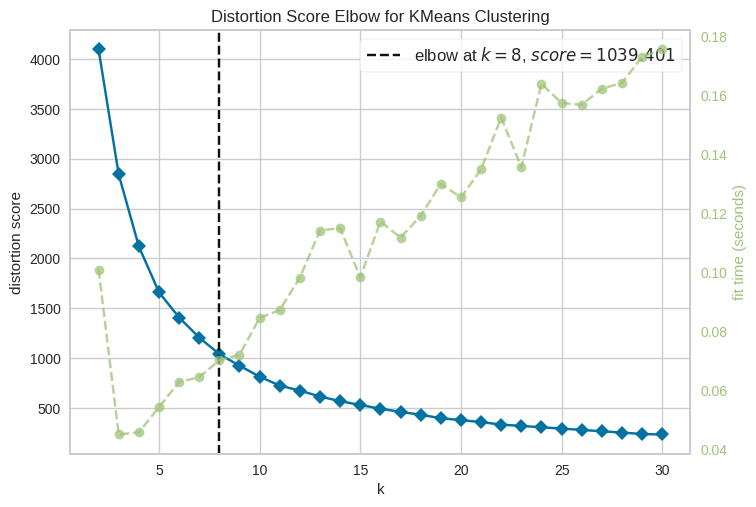

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=30)
elbow.fit(scaled_df)
elbow.show()

In [36]:
k_ = elbow.elbow_value_
print(k_)

8


In [37]:
k_means = KMeans(n_clusters=k_, random_state=99).fit(scaled_df)
segments = k_means.labels_

In [38]:
segments

array([1, 0, 2, ..., 1, 2, 7], dtype=int32)

In [39]:
rfm["KMeans_Segments"] = segments
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments
Customer ID,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,1
12347.00,4.00,2,1323.32,1.61,1.10,0
12348.00,75.00,1,221.16,4.33,0.69,2
12349.00,44.00,2,2221.14,3.81,1.10,2
12351.00,12.00,1,300.93,2.56,0.69,6


In [40]:
rfm.groupby("KMeans_Segments").agg({"Recency":["mean", "median", "count"],
                                    "Frequency":["mean","median","count"],
                                    "Monetary":["mean","median","count"]})

Recency              Frequency              Monetary              
                   mean median count      mean median count     mean  median count
KMeans_Segments                                                                   
0                  6.39   5.00   352      5.23   5.00   352  1896.92 1382.80   352
1                241.97 234.00   939      1.24   1.00   939   403.23  266.50   939
2                 69.27  66.00   790      1.43   1.00   790   533.50  378.46   790
3                 32.65  25.00   384     10.40   9.00   384  4145.36 3148.78   384
4                  6.02   5.00   214     19.23  17.00   214  7843.35 6008.61   214
5                118.37  96.00   578      4.17   4.00   578  1667.55 1234.72   578
6                 20.11  20.00   474      1.47   1.00   474   506.44  350.01   474
7                 29.66  29.00   555      4.08   4.00   555  1561.51 1189.38   555

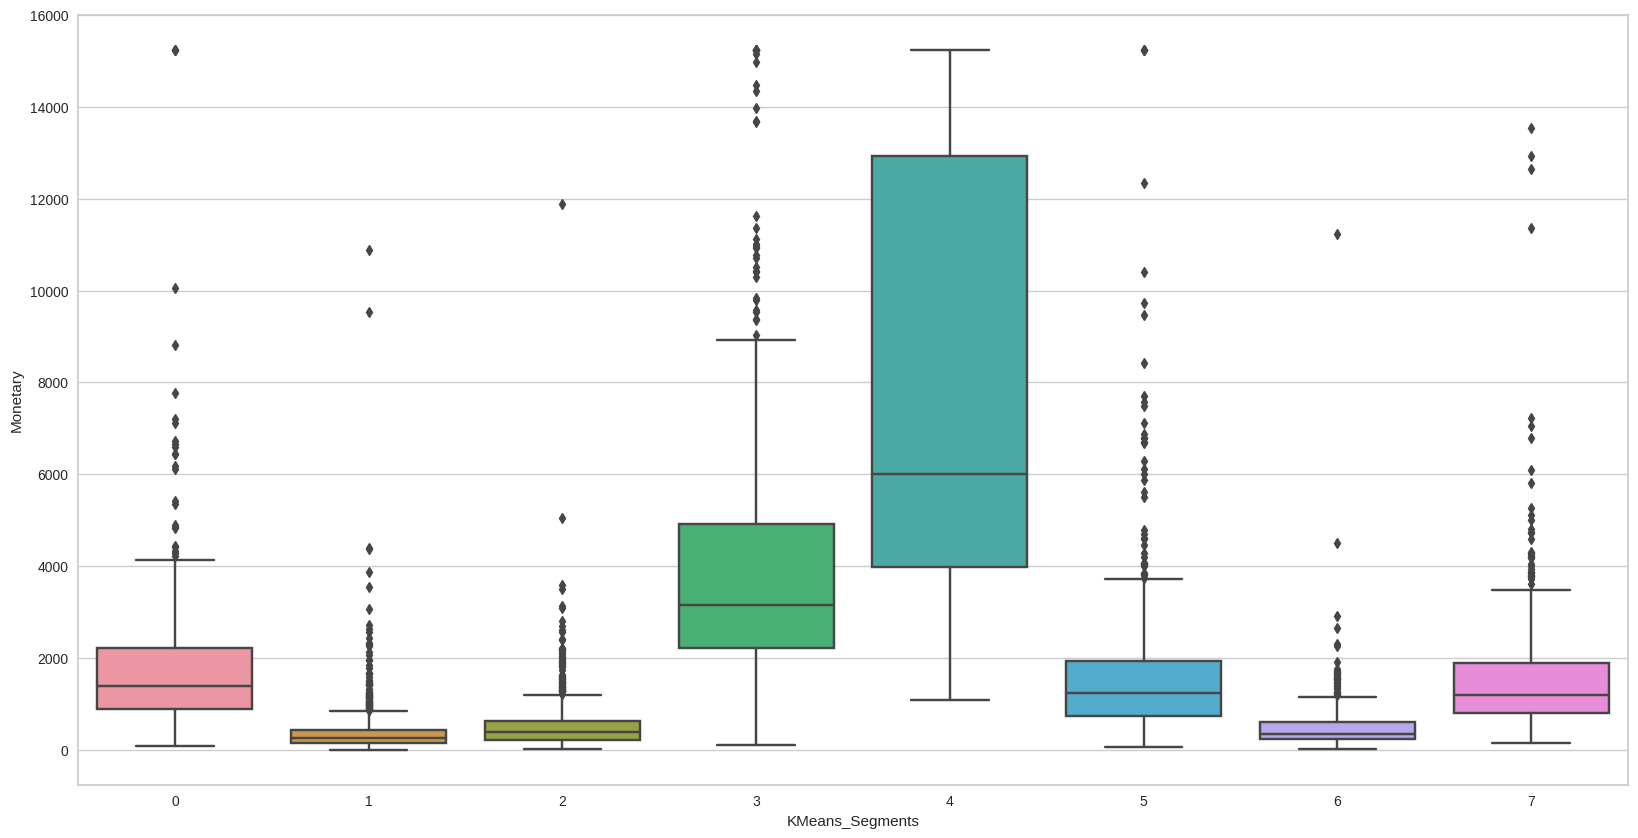

In [41]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="KMeans_Segments", y="Monetary", data=rfm)
plt.show()

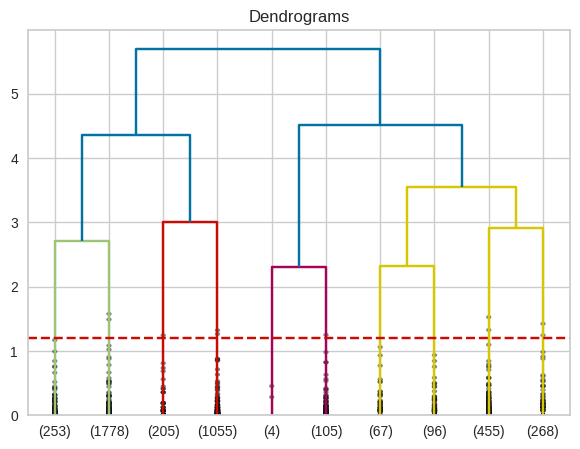

In [42]:
# Hierarchical Clustering

hc_complete = linkage(scaled_df, "complete")
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
                 truncate_mode="lastp",
                 p=10,
                 show_contracted=True,
                 leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle="--")
plt.show()

In [43]:
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(scaled_df)
rfm["Hierarchi_Segments"] = segments

In [44]:
rfm.groupby("Hierarchi_Segments").agg({"Recency":["mean","median","count"],
                                       "Frequency":["mean","median","count"],
                                       "Monetary":["mean","median","count"]})

Recency              Frequency              Monetary              
                      mean median count      mean median count     mean  median count
Hierarchi_Segments                                                                   
0                    22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                    71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                   227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                    13.24  13.00   462      2.05   2.00   462   654.60  498.73   462
4                    55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                     5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

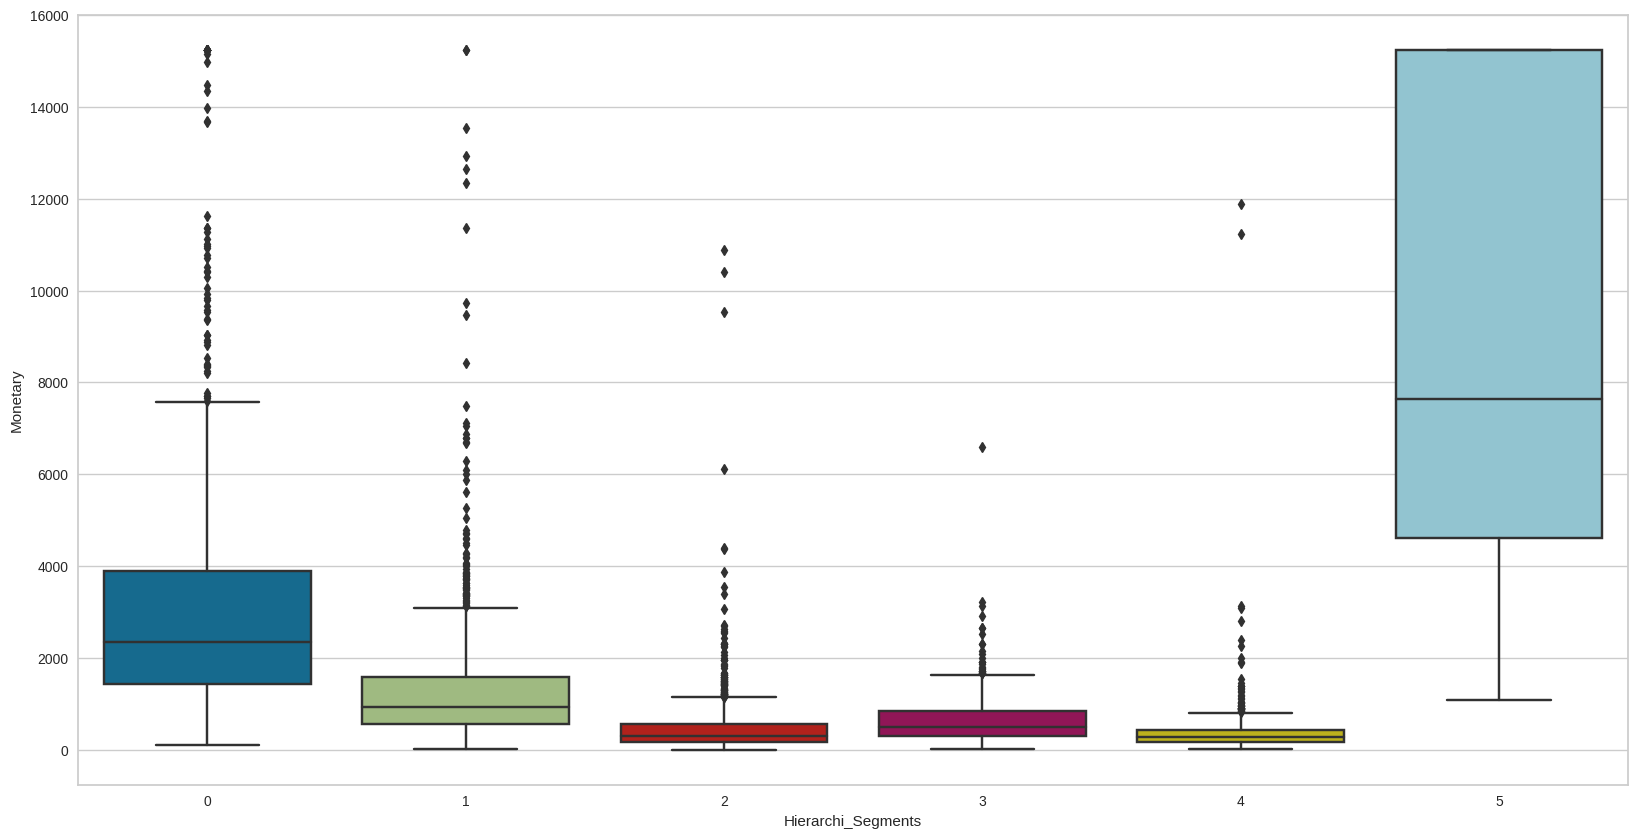

In [45]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="Hierarchi_Segments", y="Monetary", data=rfm)
plt.show()